## Context Offloading using LangGraph

In [2]:
! pip install langchain_tavily

In [3]:
## Import standard library, third-party packages
import getpass
import os
from typing_extensions import Literal

## Jupyter and display utilities  
from IPython.display import Image, display

## Pydantic for data modeling
from pydantic import BaseModel, Field

## LangChain core components
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

## LangGraph components for workflow and state management
from langgraph.graph import END, START, StateGraph, MessagesState

In [ ]:
## Define the Environment Variables and Tools

def _set_env(var: str) -> None:
    """Set environment variable if not already set.
    
    Args:
        var: Environment variable name to set
    """
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Extended state class to include scratchpad functionality
class ScratchpadState(MessagesState):
    """State that extends MessagesState to include a scratchpad field.
    
    The scratchpad provides temporary storage during agent execution,
    allowing information to persist within a single conversation thread.
    """
    scratchpad: str = Field(description="The scratchpad for storing notes")

## Set Up an API Key with TAVILY for Web Search
_set_env("TAVILY_API_KEY")

# Scratchpad management tools
@tool
class WriteToScratchpad(BaseModel):
    """Save notes to the scratchpad for future reference within the conversation."""
    notes: str = Field(description="Notes to save to the scratchpad")

@tool  
class ReadFromScratchpad(BaseModel):
    """Read previously saved notes from the scratchpad."""
    reasoning: str = Field(description="Reasoning for fetching notes from the scratchpad")

search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

In [5]:
# Initialize the language model
llm = init_chat_model("ollama:mistral:7b", temperature=0)

# Configure scratchpad tools
tools = [ReadFromScratchpad, WriteToScratchpad, search_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [6]:
## Define the Nodes

## Enhanced research planning prompt with structured workflow
scratchpad_prompt = """You are a sophisticated research assistant with access to web search and a persistent scratchpad for note-taking.

Your Research Workflow:
1. **Check Scratchpad**: Before starting a new research task, check your scratchpad to see if you have any relevant information already saved and use this to help write your research plan
2. **Create Research Plan**: Create a structured research plan
3. **Write to Scratchpad**: Save the research plan and any important information to your scratchpad
4. **Use Search**: Gather information using web search to address each aspect of your research plan
5. **Update Scratchpad**: After each search, update your scratchpad with new findings and insights
5. **Iterate**: Repeat searching and updating until you have comprehensive information
6. **Complete Task**: Provide a thorough response based on your accumulated research

Tools Available:
- WriteToScratchpad: Save research plans, findings, and progress updates
- ReadFromScratchpad: Retrieve previous research work and notes
- TavilySearch: Search the web for current information

Always maintain organized notes in your scratchpad and build upon previous research systematically."""

def llm_call(state: ScratchpadState) -> dict:
    """Execute LLM call with system prompt and conversation history.
    
    Args:
        state: Current conversation state
        
    Returns:
        Dictionary with LLM response
    """
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content=scratchpad_prompt)] + state["messages"]
            )
        ]
    }
    
def tool_node(state: ScratchpadState) -> dict:
    """Execute tool calls and manage scratchpad state updates.
    
    Handles both reading from and writing to the scratchpad, updating
    the conversation state accordingly.
    
    Args:
        state: Current conversation state with tool calls
        
    Returns:
        Dictionary with tool results and updated state
    """
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        if tool_call["name"] == "WriteToScratchpad":
            ## Save notes to scratchpad and update state
            notes = observation.notes
            result.append(ToolMessage(content=f"Wrote to scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result, "scratchpad": notes}
        elif tool_call["name"] == "ReadFromScratchpad":
            ## Retrieve notes from scratchpad state
            notes = state.get("scratchpad", "")
            result.append(ToolMessage(content=f"Notes from scratchpad: {notes}", tool_call_id=tool_call["id"]))
            update = {"messages": result}
        elif tool_call["name"] == "tavily_search":
            ## Write search tool observation to messages
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            update = {"messages": result}
    return update

def should_continue(state: ScratchpadState) -> Literal["tool_node", "__end__"]:
    """Determine workflow continuation based on tool calls.
    
    Args:
        state: Current conversation state
        
    Returns:
        Next node name or END
    """
    messages = state["messages"]
    last_message = messages[-1]
    return "tool_node" if last_message.tool_calls else END


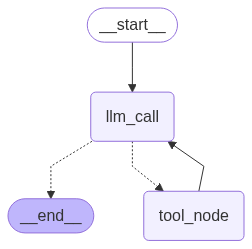

In [7]:
## Build the scratchpad workflow
agent_builder = StateGraph(ScratchpadState)

## Add the Nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

## Define the edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"tool_node": "tool_node", END: END})
agent_builder.add_edge("tool_node", "llm_call")
agent = agent_builder.compile()

## Display the workflow 
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
## Invoke the Agent
from langchain_core.messages import HumanMessage
query = "Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy."
state = agent.invoke({"messages": [HumanMessage(content=query)]})

In [9]:
## Defining Different Users based on Message Response
from typing import Iterable, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

def _role_of(msg: Any) -> str:
    """Infer a role string from LangChain message objects or dicts."""
    if isinstance(msg, HumanMessage):
        return "User"
    if isinstance(msg, AIMessage):
        return "Agent"
    if isinstance(msg, SystemMessage):
        return "System"
    if isinstance(msg, ToolMessage):
        return "AI Tool"
    if isinstance(msg, BaseMessage):
        ## Fallback for other BaseMessage subclasses
        return getattr(msg, "type", msg.__class__.__name__.lower())
    if isinstance(msg, dict):
        return msg.get("role", "unknown")
    return msg.__class__.__name__.lower()

def _content_of(msg: Any) -> str:
    """Extract textual content from LangChain message objects or dicts."""
    if isinstance(msg, BaseMessage):
        c = msg.content
        return c if isinstance(c, str) else str(c)
    if isinstance(msg, dict):
        return str(msg.get("content", ""))
    return str(msg)

In [10]:
## Define the format messages
def format_messages(messages: Iterable[Any]) -> str:
    """
    Pretty-print a sequence of chat messages.
    Supports LangChain BaseMessage subclasses and dicts with {'role','content'}.
    Also prints AI tool calls if present.
    """
    lines = []
    for m in messages:
        role = _role_of(m).capitalize()
        content = _content_of(m)

        ## Handle AI tool calls (LangChain >= 0.2 exposes .tool_calls on AIMessage)
        tool_calls_txt = ""
        if isinstance(m, AIMessage):
            tool_calls = getattr(m, "tool_calls", None)
            if tool_calls:
                parts = []
                for tc in tool_calls:
                    name = tc.get("name") or tc.get("function", {}).get("name") or "tool"
                    args = tc.get("args") or tc.get("function", {}).get("arguments")
                    parts.append(f"- call {name}({args})")
                tool_calls_txt = ("\nTool calls:\n" + "\n".join(parts)) if parts else ""

        if isinstance(m, ToolMessage):
            tool_name = getattr(m, "name", "tool")
            lines.append(f"Tool ({tool_name}): {content}")
        else:
            lines.append(f"{role}: {content}{tool_calls_txt}")

    return "\n".join(lines)

In [12]:
## Format and display results
print(format_messages(state['messages']))

User: Compare the funding rounds and recent developments of Commonwealth Fusion Systems vs Helion Energy.
Agent:  To compare the funding rounds and recent developments of Commonwealth Fusion Systems (CFS) vs Helion Energy, I will first gather information about each company's funding history and significant milestones.

**Commonwealth Fusion Systems:**
- Funding Rounds:
  - Series A: $13 million in 2017 led by Breakthrough Energy Ventures (BEV)
  - Series B: $500 million in 2020 led by BEV, Atomico, and Eclipse Ventures
- Recent Developments:
  - In July 2021, CFS announced a partnership with MIT to build SPARC, the world's first fusion power plant.
  - In October 2021, CFS raised an additional $350 million in funding for the construction of SPARC.

**Helion Energy:**
- Funding Rounds:
  - Seed Round: $6 million in 2018 led by Breakthrough Energy Ventures (BEV) and Energy Innovation Capital
  - Series A: $135 million in 2020 led by BEV, Temasek, and Capricorn Investment Group
- Recent D

### Data Persistence

- In this above example we are storing the Context: Research plan in a Scratchpad that is enabled using the state object that persists throughout the LLM Agent Process

- However, this data will only be available throughout the lifecycle of the agent and would not be available post

- Solution: InMemoryStore (Memory to Save Information)
    - To Mitigate this and in case we want data to persist across different agent lifecycles so that we can use that data for tasks ahead or that another agent can access this data, we can use the InMemoryStore present in LangGraph

    - This let's us save information in memory and can be accessed in different threads (different agent lifecycles) for complex tasks or in case we need this information to be fed to a new thread or agent in the process.

    - For Production, this can be backed up to Redis/PostGreSQL for optimal data storage and usage